## Problem Statement and Introduction

Enhancing product utilization and increasing wallet share are critical objectives for financial institutions, representing key performance indicators (KPIs) in a competitive and dynamic market. Acquiring new customers entails significant costs; however, leveraging existing customer relationships to cross-sell additional products offers a more cost-effective strategy. This approach capitalizes on established connections with customers, reducing the need for extensive marketing efforts while fostering engagement and loyalty with the brand.

In response to this need, I have developed a data science model tailored to the banking industry, aimed at identifying the next best product for financial institutions to offer their existing customers. By analyzing relevant data sources, such as transaction histories and demographic information, the model predicts optimal product recommendations, aligning with individual customer preferences and financial needs. This proactive approach not only drives revenue growth but also strengthens customer relationships, positioning banks for long-term success in a competitive marketplace.

### import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from tqdm import tqdm

## Load the Datsetset and Description

The data comes from Santander Bank and spans approximately 1.5 years, starting from January 28, 2015, with monthly records detailing the products each customer possesses, such as "credit card," "savings account," etc.

The objective is to forecast the additional products a customer will acquire in the upcoming months, in addition to their current holdings. To streamline the process, only 30,000 records have been utilized.

In [2]:
raw_df = pd.read_csv('Dataset', nrows=30000)

In [3]:
#Description of data and name of variable
data_desc = pd.read_csv('data_desc.csv')

## Exploring and Cleaning the dataset


It is essential to check the data quality before performing any analyses. The first thing I would like to do is to check the percentage of missing data in each record.

In [6]:
#Checkign the percentages of missing value in each record
raw_df.isnull().mean() * 100

Date                       0.000000
CustomerID                 0.000000
EmployeeID                 0.646667
CustomerLocation           0.646667
Gender                     0.646667
Age                        0.000000
DateJoined                 0.646667
CustomerIndex              0.646667
Tenure                     0.000000
FirstPrimaryCustomer       0.646667
LastPrimaryCustomer       99.883333
CustomerType               0.646667
RelationType               0.646667
ResidenceIndex             0.646667
IndexJoSed                 0.646667
SpouseIndex              100.000000
ChannelUsed                0.646667
DeceasedIndex              0.646667
AddresType                 0.646667
ProvinceCode               0.680000
ProvinceName               0.680000
ActivityIndex              0.646667
HGrossIcome               18.460000
SegmentID                  0.650000
SavingAccount              0.000000
Guarantees                 0.000000
CurrentAccounts            0.000000
DerivativeAccount          0


It appears that there are several records with significant missing values. Therefore, I would like to drop the records that have more than 90% missing values.

In [7]:
# Drop record with more than 90% of missing value
data = raw_df.dropna(axis=1, thresh=0.90 *len(raw_df.columns))


There are two common data types in the dataset: categorical and continuous (numerical). To facilitate preprocessing, I will specify and group each data type in a list.

In [8]:
# Specificying Data Type
categorical_cols = ['CustomerLocation','Gender','CustomerIndex', 'FirstPrimaryCustomer','RelationType','ResidenceIndex', 'IndexJoSed','ChannelUsed','DeceasedIndex', 'ProvinceCode','ActivityIndex','SegmentID']
numerical_cols = ['Age','Tenure', 'HGrossIcome',]

The dataset includes information on the products utilized or the list of products used by the consumer. It would be beneficial to identify those variables as well.

In [9]:
# Specificying list of products
products = data.iloc[:, 22:]

It appears that there are records where the consumer has not utilized any product. Since our focus is mainly on product utilization, next I would drop those records where product utilizations are missing.

In [10]:
# Drop records where product usage is missing
data = data.dropna(subset=products.columns)

In [11]:
# Replace 'NA' with NaN
data.replace(' NA', np.nan, inplace=True)

# Handle missing values
data.dropna(inplace=True)

In [12]:
products = data.iloc[:, 22:]

In [13]:
# Check data after droping the missing value 
data.isnull().mean()*100

Date                     0.0
CustomerID               0.0
EmployeeID               0.0
CustomerLocation         0.0
Gender                   0.0
Age                      0.0
DateJoined               0.0
CustomerIndex            0.0
Tenure                   0.0
FirstPrimaryCustomer     0.0
CustomerType             0.0
RelationType             0.0
ResidenceIndex           0.0
IndexJoSed               0.0
ChannelUsed              0.0
DeceasedIndex            0.0
AddresType               0.0
ProvinceCode             0.0
ProvinceName             0.0
ActivityIndex            0.0
HGrossIcome              0.0
SegmentID                0.0
SavingAccount            0.0
Guarantees               0.0
CurrentAccounts          0.0
DerivativeAccount        0.0
PayrollAccount           0.0
JuniorAccount            0.0
AccountLocation          0.0
ParticularAccount        0.0
ParticularPlusAccount    0.0
ShortTermDeposit         0.0
MediumTermDeposit        0.0
LongTermDeposit          0.0
E-Account     

## Visualize Produt Usage

Visual representation of product usage provides a clear and intuitive way to understand customer behavior and preferences. 
To create the plot, the code sets the graph style and initializes an empty DataFrame to store the counts of product usage. It then iterates over each product column, counting occurrences of '1', which indicate product usage. These counts are aggregated and stored in the DataFrame, along with the corresponding product column name.
After calculating the total count for each product, the DataFrame is sorted by the total count in descending order to prioritize the most frequently used products. The bar plot is then generated using seaborn, with the x-axis representing the products and the y-axis representing the count of product usage. Additionally, the hue parameter is utilized to distinguish between products that are used ('1') and not used ('0').


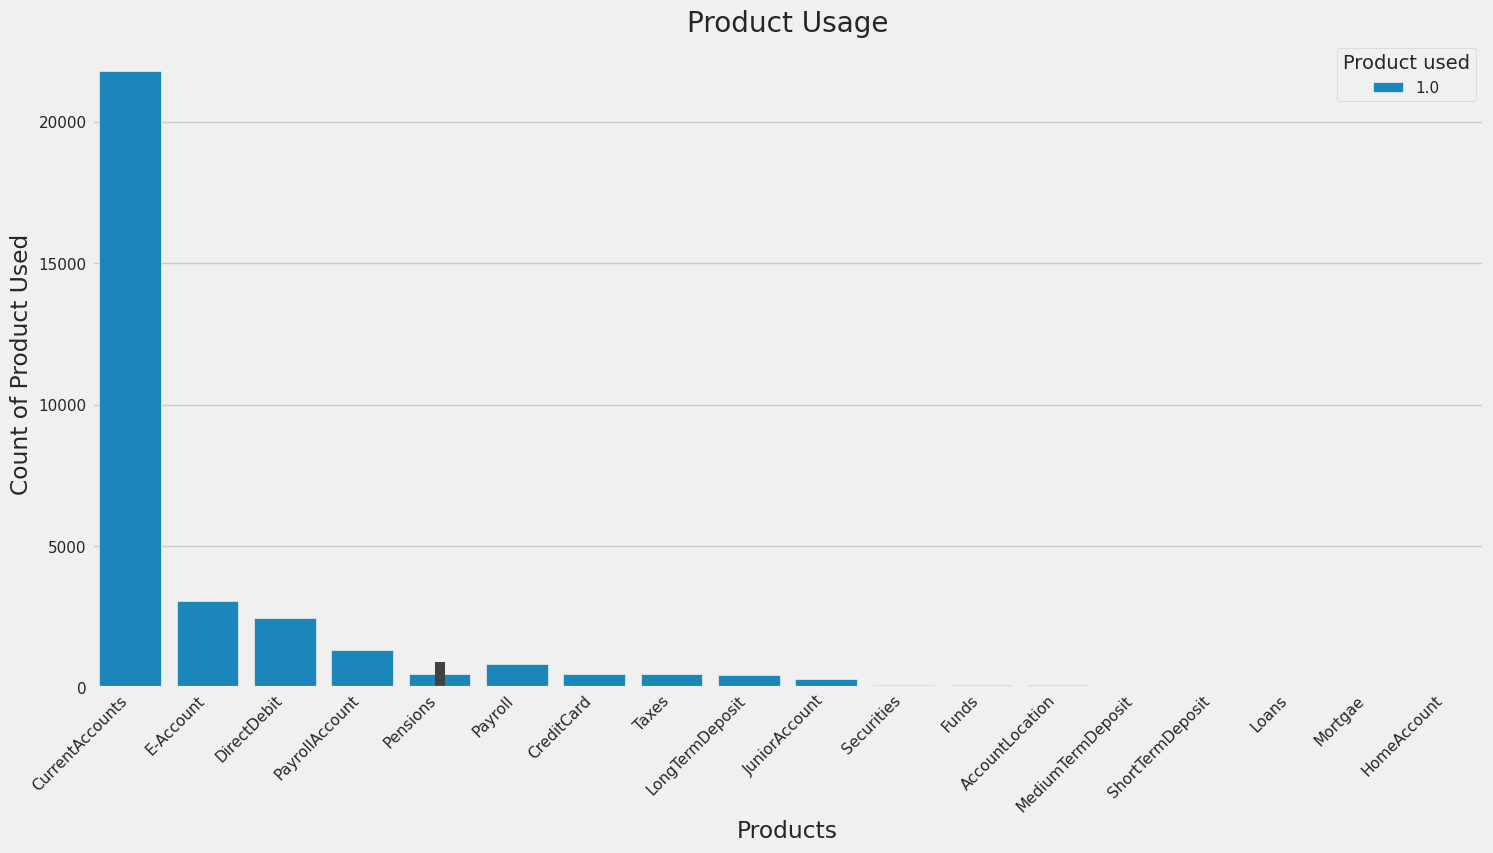

In [14]:
# Set graph style
plt.style.use('fivethirtyeight')

# Empty DataFrame to store the counts
counts = pd.DataFrame(columns=['column', 'count'])

# Iterate over each column and count occurrences of '1'
for column_name, column_data in products.items():
    # Convert the column data to Series
    column_data_series = pd.Series(column_data)
    column_counts = column_data_series.value_counts().reset_index()
    column_counts.columns = ['value', 'count']
    # Append the column index as the 'column' value
    column_counts['column'] = column_name
    counts = pd.concat([counts, column_counts[column_counts['value'] == 1]], ignore_index=True)

# Calculate the total count for each product
total_counts = counts.groupby('column')['count'].sum().reset_index()

# Sort the DataFrame by the total count in descending order
total_counts = total_counts.sort_values(by='count', ascending=False)

plt.figure(figsize=(16, 8))

ax = sns.barplot(x=counts['column'], y=counts['count'], hue=counts['value'], order=total_counts['column'])
ax.set_title("Product Usage")
ax.set_xlabel("Products")
ax.set_ylabel("Count of Product Used")
ax.legend(title="Product used", title_fontsize="14")

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()


## Fiting Models


The objective is to forecast the subsequent optimal product. The target encompasses a list of products, while the features entail the customer characteristics. To accomplish this objective, the XGBoost Multiclass Classifier emerges as the most fitting model. This classifier is adept at handling multiple classes and is well-suited to the task of predicting the next best product based on diverse customer attributes. With its robust performance and ability to handle complex data relationships, the XGBoost Multiclass Classifier stands poised to provide accurate predictions, thereby facilitating informed decision-making in product recommendation systems.


The first step is to specify the target and the features.

In [15]:
# features and labels
X = data[categorical_cols + numerical_cols]
y = products

Following the specification of the target and features, the subsequent crucial step involves partitioning the dataset into training and test sets. This partitioning ensures the model's ability to generalize well to unseen data. Typically, a portion of the dataset, usually around 70-80%, is allocated for training the model, while the remaining portion, around 20-30%, is reserved for evaluating its performance. This segregation helps assess the model's effectiveness in predicting new instances accurately.

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Defining Pipeline

The pipeline is defined to preprocess both numerical and categorical columns efficiently. For numerical columns, missing values are imputed using the median as the strategy, followed by scaling through standardization. Meanwhile, for categorical columns, missing values are imputed using the most frequent value strategy, and then one-hot encoding is applied, with the ability to handle unknown categories. These steps are consolidated using the ColumnTransformer.

The preprocessing pipeline is integrated into the overall pipeline, which includes a MultiOutputClassifier utilizing the XGBoost algorithm. This classifier is capable of handling multiple classes, making it suitable for the task at hand. The full pipeline encompasses the preprocessing steps and the classifier.

To train the model, the pipeline is fitted to the training data. This process ensures that the model learns from the training set while incorporating the preprocessing steps to handle various data types effectively. Upon completion of the fitting process, the pipeline is ready to make predictions on new data, providing insights into the next best product based on customer characteristics.

In [17]:
# Define preprocessing steps for numerical and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Construct the full pipeline with MultiOutputClassifier and XGBoost
classifier = MultiOutputClassifier(XGBClassifier())

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train);

After making predictions using the defined pipeline, the next step involves evaluating the model's performance metrics such as precision and recall. Precision measures the proportion of correctly predicted positive cases out of all predicted positive cases, while recall calculates the proportion of correctly predicted positive cases out of all actual positive cases. These metrics are crucial for assessing the model's ability to accurately classify each label.
belo, the predictions are made on the test data using the pipeline. Subsequently, precision and recall scores are computed for each label using the precision_score and recall_score functions, respectively, with the 'micro' averaging strategy. 'Micro' averaging calculates metrics globally by considering each element of the label indicator matrix as an individual data point.
Finally, the computed precision and recall scores are printed to provide insights into the model's performance. These metrics offer valuable information about the model's effectiveness in predicting the next best product based on customer characteristics. Higher precision and recall scores indicate better performance, reflecting the model's ability to make accurate predictions while minimizing false positives and false negatives.


In [18]:
# Make predictions
y_pred = pipeline.predict(X_test)

# precision and recall for each label
precision = precision_score(y_test, y_pred, average='micro')  
recall = recall_score(y_test, y_pred, average='micro')  

print(f'Precision: {precision}')
print(f'Recall: {recall}')


Precision: 0.8373056994818653
Recall: 0.7471104946833103


### Hyperparameter Tuning 

Hyperparameter tuning is a crucial step in optimizing the performance of machine learning models. It involves systematically searching through a range of hyperparameters to find the combination that yields the best results. In the context of XGBoost, various hyperparameters such as learning rate, number of estimators, maximum depth, and minimum child weight significantly impact the model's performance.
I have used grid search, a parameter grid for XGBoost is defined, encompassing different values for these hyperparameters. The grid serves as a blueprint for exploring various combinations during the tuning process. Additionally, scoring metrics such as precision and recall are specified to evaluate the model's performance.
To conduct the hyperparameter search, a GridSearchCV object is utilized, iterating over each parameter in the grid. For each parameter, the pipeline is fitted to the training data using cross-validation, and the specified scoring metrics are computed. The best combination of hyperparameters is determined based on the highest precision score, as specified by the 'precision_micro' metric.
Throughout the grid search loop, the progress is tracked using tqdm to provide visibility into the process. After completing the search, the best set of parameters and corresponding precision and recall scores are identified. These results offer insights into the optimal configuration for the XGBoost model, ensuring enhanced performance in predicting the next best product based on customer characteristics.


In [19]:
# Parameter grid for XGBoost
param_grid = {
    'classifier__estimator__learning_rate': [0.1, 0.01, 0.001],
    'classifier__estimator__n_estimators': [100, 200, 300],
    'classifier__estimator__max_depth': [1, 2, 3, 5, 7],
    'classifier__estimator__min_child_weight': [1, 3, 5],
}

# Scoring metrics
scoring = {
    'precision_micro': make_scorer(precision_score, average='micro'),
    'recall_micro': make_scorer(recall_score, average='micro'),
}

# List to store the results
results = []

# Grid search loop
with tqdm(total=len(param_grid.keys()), desc='Parameter Grid') as pbar:
    for params in param_grid.keys():
        grid_search = GridSearchCV(pipeline, {params: param_grid[params]}, scoring=scoring, refit='precision_micro', cv=5)
        grid_search.fit(X_train, y_train)

        # Best parameters and scores
        best_params = grid_search.best_params_
        precision_micro = grid_search.best_score_
        recall_micro = grid_search.cv_results_['mean_test_recall_micro'][grid_search.best_index_]

        # Append to the results list
        results.append((best_params, precision_micro, recall_micro))

        # Update the progress bar
        pbar.update(1)

# Find the best set of parameters
best_results = max(results, key=lambda x: x[1])

print(f'Best Parameters: {best_results[0]}')
print(f'Precision (micro): {best_results[1]}')
print(f'Recall (micro): {best_results[2]}')

Parameter Grid: 100%|██████████| 4/4 [01:42<00:00, 25.62s/it]

Best Parameters: {'classifier__estimator__learning_rate': 0.01}
Precision (micro): 0.9033071769447139
Recall (micro): 0.6879281248874873


### Predicting the Next Best Products


The next and one of the most import step is predicting the next best product. Below my focuses is on predicting the top three best products for each customer based on their characteristics. Initially, predictions are made using the pipeline, resulting in probability estimates for each product. These probabilities represent the likelihood of a customer purchasing each product.
Next, the positive class probabilities are extracted from the predictions, indicating the likelihood of a positive outcome (i.e., purchase) for each product. These probabilities are organized into a DataFrame, with customer IDs as the index and product names as columns.
To recommend the top three products for each customer, a loop iterates over the DataFrame, sorting the products based on their probabilities in descending order. The top N recommendations, where N is set to three, are then extracted along with their corresponding probabilities.
The recommendations, along with the associated customer IDs and probabilities, are stored in a new DataFrame. This DataFrame provides a clear overview of the top product recommendations for each customer, facilitating targeted marketing efforts and personalized customer experiences.


In [20]:
# Make predictions
predictions_probabilities = np.array(pipeline.predict_proba(X))

# Extract the probability of the positive class for each sample
positive_class_probabilities = predictions_probabilities[:, :, 1]

# 'ID' column is set as the index in the main data
results_df = pd.DataFrame(positive_class_probabilities.T, index=X.index, columns=y.columns)

# Recommend top 3 products for each customer
top_n = 3
recommendations = []

for customer_id, row in results_df.iterrows():
    # Get the top N recommendations with their probabilities
    top_recommendations = row.sort_values(ascending=False).head(top_n)
    customer_recommendations = list(top_recommendations.index)
    probabilities = list(top_recommendations)

    recommendations.append((customer_id, customer_recommendations, probabilities))

# Create a DataFrame for recommendations
columns = ['CustomerID', 'RecommendedProducts', 'Probabilities']
recommendations_df = pd.DataFrame(recommendations, columns=columns)

# Display or return the recommendations DataFrame
recommendations_df.head(10)


,CustomerID,RecommendedProducts,Probabilities
0,0,"[CurrentAccounts, Taxes, Payroll]","[0.8437610864639282, 0.16579611599445343, 0.10..."
1,1,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.9986586570739746, 0.001650498597882688, 0.0..."
2,2,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.9994460940361023, 0.009469190612435341, 0.0..."
3,3,"[CurrentAccounts, ShortTermDeposit, DirectDebit]","[0.9898906946182251, 0.07415647804737091, 0.00..."
4,5,"[CurrentAccounts, PayrollAccount, DirectDebit]","[0.9961267113685608, 0.0006915698759257793, 0...."
5,6,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.99237060546875, 0.00492744380608201, 0.0011..."
6,7,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.9748056530952454, 0.0428437776863575, 0.020..."
7,9,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.999569833278656, 0.00226560328155756, 0.000..."
8,10,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.9960457682609558, 0.001092532416805625, 0.0..."
9,12,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.9907055497169495, 0.08919207751750946, 0.01..."


### Highest Likelihood 

It's essential to acknowledge that the likelihood of customers adopting a product varies significantly across different individuals. While some customers may have a high probability of using certain products, others may exhibit lower probabilities. Thus, it's valuable to distinguish between customers who are highly likely to adopt a product and those with lower probabilities. This allows for targeted marketing strategies tailored to each customer segment.
To highlight these distinctions, would be good to sorts the recommendations DataFrame based on the probability of using the first recommended product. This sorting enables the identification of customers with the highest likelihood of product adoption. By organizing the recommendations in descending order of this probability, customers with the highest potential for product adoption are prioritized.


In [21]:
#Highest probabiliteis of use
columns = ['CustomerID', 'RecommendedProducts', 'Probabilities']
recommendations_df = pd.DataFrame(recommendations, columns=columns)

# Sort the DataFrame based on the probability of using the first product
recommendations_df['FirstProductProbability'] = recommendations_df['Probabilities'].apply(lambda x: x[0] if x else None)
recommendations_df.sort_values(by='FirstProductProbability', ascending=False, inplace=True)

# Display or return the sorted recommendations DataFrame
recommendations_df.drop(columns='FirstProductProbability', inplace=True)  # Remove the temporary column used for sorting
recommendations_df.head(20)

,CustomerID,RecommendedProducts,Probabilities
21198,26143,"[CurrentAccounts, PayrollAccount, Taxes]","[0.9998573064804077, 0.003127041971310973, 0.0..."
1860,2258,"[CurrentAccounts, DirectDebit, Taxes]","[0.9998164772987366, 0.003289386397227645, 0.0..."
3203,3946,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.999815046787262, 0.00033545453334227204, 0...."
5663,6983,"[CurrentAccounts, PayrollAccount, DirectDebit]","[0.9997919201850891, 0.00033206501393578947, 0..."
21084,26007,"[CurrentAccounts, PayrollAccount, Taxes]","[0.9997898936271667, 0.0022178676445037127, 0...."
20803,25661,"[CurrentAccounts, PayrollAccount, Taxes]","[0.9997890591621399, 0.0014046764699742198, 0...."
6756,8325,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.9997887015342712, 0.0005132952937856317, 0...."
3886,4766,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.9997887015342712, 0.0005132952937856317, 0...."
3883,4763,"[CurrentAccounts, DirectDebit, Taxes]","[0.9997721314430237, 0.0012229663552716374, 0...."
5664,6984,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.9997671246528625, 0.0013252388453111053, 0...."


### Lowest Likelihood

To complement the analysis of high likelihoods of product adoption, it's equally important to consider customers with lower probabilities. These customers may require different marketing approaches or additional incentives to encourage product adoption. After sorting the recommendations DataFrame based on the probability of using the first recommended product, the last records are displayed. This action effectively showcases customers with the lowest likelihoods of product adoption.

In [22]:
#Lowesst probabiliteis of use
recommendations_df.tail(20)

,CustomerID,RecommendedProducts,Probabilities
19934,24649,"[CurrentAccounts, E-Account, LongTermDeposit]","[0.3696228861808777, 0.27159178256988525, 0.18..."
15999,19899,"[CurrentAccounts, E-Account, Taxes]","[0.3684486746788025, 0.2531980276107788, 0.009..."
448,544,"[CurrentAccounts, DirectDebit, PayrollAccount]","[0.36789920926094055, 0.2640500068664551, 0.13..."
2435,2988,"[Securities, E-Account, AccountLocation]","[0.36304575204849243, 0.3132633566856384, 0.21..."
21811,26862,"[CurrentAccounts, E-Account, Taxes]","[0.3606700599193573, 0.23813164234161377, 0.05..."
2431,2984,"[CurrentAccounts, E-Account, AccountLocation]","[0.3591054379940033, 0.3526366055011749, 0.009..."
20145,24887,"[CurrentAccounts, E-Account, Pensions]","[0.3570042848587036, 0.26116228103637695, 0.19..."
18536,22972,"[E-Account, JuniorAccount, CurrentAccounts]","[0.3471429944038391, 0.3197192847728729, 0.253..."
3946,4838,"[E-Account, CurrentAccounts, LongTermDeposit]","[0.32677412033081055, 0.31506067514419556, 0.2..."
2293,2811,"[CurrentAccounts, E-Account, DirectDebit]","[0.31380483508110046, 0.25918737053871155, 0.0..."
